## **Google Colab - Download dataset from GitHub**




In [1]:
!wget https://github.com/RWaiti/teste/archive/refs/heads/main.zip

--2021-10-05 17:52:38--  https://github.com/RWaiti/teste/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/RWaiti/teste/zip/refs/heads/main [following]
--2021-10-05 17:52:38--  https://codeload.github.com/RWaiti/teste/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.113.9
Connecting to codeload.github.com (codeload.github.com)|140.82.113.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [ <=>                ] 416.64M  30.3MB/s    in 14s     

2021-10-05 17:52:52 (30.6 MB/s) - ‘main.zip’ saved [436876685]



## **Unzip dataset**




In [2]:
!7z x main.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 436876685 bytes (417 MiB)

Extracting archive: main.zip
 59% 4096 Open              --
Path = main.zip
Type = zip
Physical Size = 436876685
Comment = 540cde38ba7c4bb771249c9d869294eb3bd14746

  0%      3% 208 - teste-main/data/pokemon/Arcanine_31.jpg                                                    7% 375 - teste-main/data/pokemon/Blastoise_38.jpg                                                    10% 545 - teste-main/data/pokemon/Charizard_2.jpg

## **Code**




In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as imgplt
import numpy as np
from tensorflow import keras,test

####### LOCAL PATH #######
path_data = 'data'

####### GOOGLE COLAB UNZIP PATH #######
# path_data = 'teste-main/data' 

input_shape = (224, 224)
batch_size = 16
epochs_size = 80

def plot_ai(history):
  plt.plot(np.dot(history['accuracy'],100))
  plt.plot(np.dot(history['val_accuracy'],100))
  plt.title('model train vs validation accuracy')
  plt.ylabel('accuracy - %')
  plt.xlabel('epoch')
  plt.yticks([0,10,20,30,40,50,60,70,80,90,100])
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('model train vs validation loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()


In [22]:
if test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [23]:
df = pd.read_csv(path_data + '/pokemon.csv')
df = df.sample(frac=1, random_state=42)

test_split = 0.8

df_train = df.iloc[:int(len(df) * test_split)]
df_test = df.iloc[int(len(df) * test_split):]

df_train.head()

,file,Abra,Aerodactyl,Alakazam,Alolan Sandslash,Arbok,Arcanine,Articuno,Beedrill,Bellsprout,Blastoise,Bulbasaur,Butterfree,Caterpie,Chansey,Charizard,Charmander,Charmeleon,Clefable,Clefairy,Cloyster,Cubone,Dewgong,Diglett,Ditto,Dodrio,Doduo,Dragonair,Dragonite,Dratini,Drowzee,Dugtrio,Eevee,Ekans,Electabuzz,Electrode,Exeggcute,Exeggutor,Farfetchd,Fearow,...,Psyduck,Raichu,Rapidash,Raticate,Rattata,Rhydon,Rhyhorn,Sandshrew,Sandslash,Scyther,Seadra,Seaking,Seel,Shellder,Slowbro,Slowpoke,Snorlax,Spearow,Squirtle,Starmie,Staryu,Tangela,Tauros,Tentacool,Tentacruel,Vaporeon,Venomoth,Venonat,Venusaur,Victreebel,Vileplume,Voltorb,Vulpix,Wartortle,Weedle,Weepinbell,Weezing,Wigglytuff,Zapdos,Zubat
101,Lapras_8.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2666,Ponyta_30.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3838,Oddish_22.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2388,Raticate_32.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5438,Dragonair_16.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


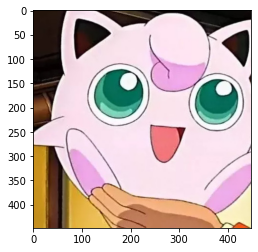

In [24]:
file = df_train['file'].iloc[1000]
img = imgplt.imread(os.path.join(path_data, file))
plt.imshow(img)
plt.show()

In [25]:
labels = list(df.columns.values)
labels.remove('file')

## **Data Augmentation**

In [26]:
generator = keras.preprocessing.image.ImageDataGenerator(samplewise_center=True,
                                                         samplewise_std_normalization=True)
generator_train = keras.preprocessing.image.ImageDataGenerator(samplewise_center=True,
                                                               samplewise_std_normalization=True,
                                                               rotation_range=45,
                                                               horizontal_flip = True,
                                                               width_shift_range=.2,
                                                               height_shift_range=.2,
                                                               zoom_range=.2,
                                                               shear_range =.2,
                                                               fill_mode="nearest")# Data augmentation
                                                               
generator_train = generator_train.flow_from_dataframe(dataframe=df_train,
                                               directory=path_data + '/pokemon',
                                               x_col='file',
                                               y_col=labels,
                                               class_mode='raw',
                                               batch_size=batch_size,
                                               shuffle=False,
                                               target_size=(224, 224))

generator_test = generator.flow_from_dataframe(dataframe=df_test,
                                               directory=path_data + '/pokemon',
                                               x_col='file',
                                               y_col=labels,
                                               class_mode='raw',
                                               batch_size=batch_size,
                                               shuffle=False,
                                               target_size=(224, 224))

Found 5457 validated image filenames.
Found 1364 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 3 invalid image filename(s) in x_col="file". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="file". These filename(s) will be ignored.
  .format(n_invalid, x_col)


## **150 Pokemons classes**
## **Mean of 45 for each class**
## **Unbalanced**

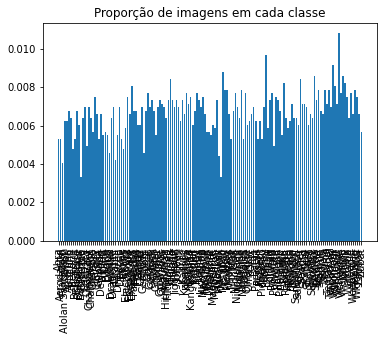

In [27]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(generator_train.labels, axis=0))
plt.title("Proporção de imagens em cada classe")
plt.show()

## **Creating a Class Weights to correct the unbalanced training data**

In [28]:
from sklearn.utils import class_weight
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

y_linear = [i.argmax() for i in generator_train.labels] # Transformando do formato y one-hot para o formato y vetor linear

weights_vector = class_weight.compute_class_weight('balanced',
                                                  np.unique(y_linear),
                                                  y_linear) # Encontra os pesos balanceados considerando a quantidade de cada

weights_dict = dict(enumerate(weights_vector)) # transforma o vetor de pesos balanceados em dict para usar no model.fit()

print(weights_dict)

{0: 1.2544827586206897, 1: 1.2544827586206897, 2: 1.6536363636363636, 3: 1.07, 4: 1.07, 5: 0.9832432432432432, 6: 1.0394285714285714, 7: 1.3992307692307693, 8: 1.2544827586206897, 9: 0.9832432432432432, 10: 1.1024242424242425, 11: 2.0211111111111113, 12: 1.0394285714285714, 13: 0.9573684210526315, 14: 1.3474074074074074, 15: 0.9573684210526315, 16: 1.0394285714285714, 17: 1.1735483870967742, 18: 0.8873170731707317, 19: 1.0105555555555557, 20: 1.2544827586206897, 21: 1.0105555555555557, 22: 1.2126666666666666, 23: 1.1735483870967742, 24: 1.2126666666666666, 25: 1.4552, 26: 1.0394285714285714, 27: 0.9573684210526315, 28: 1.5817391304347825, 29: 1.2126666666666666, 30: 0.9573684210526315, 31: 1.2544827586206897, 32: 1.3992307692307693, 33: 1.136875, 34: 0.8873170731707317, 35: 1.0105555555555557, 36: 0.8268181818181818, 37: 0.9832432432432432, 38: 0.9832432432432432, 39: 1.1024242424242425, 40: 1.1024242424242425, 41: 0.9573684210526315, 42: 1.4552, 43: 0.9832432432432432, 44: 0.866190476

# **Model using ResNet.v2 with TransferLearning and some deactivated layers**




In [35]:
# Crie aqui o seu modelo
# Para compatibilidade do código das próximas células, o modelo deve ser salvo
# em uma variável chamada 'model'
# INÍCIO DO CÓDIGO
inputs = keras.layers.Input(shape=(224,224,3))

model_prev = keras.applications.resnet_v2.ResNet50V2(include_top=False,
                                                     weights='imagenet',
                                                     input_tensor=inputs)
for i in range(0,len(model_prev.layers),4):#Desativando apenas algumas camadas
  model_prev.layers[i].trainable = False

x = keras.layers.SpatialDropout2D(0.7)(model_prev.output)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(784, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.AlphaDropout(0.7)(x)
outputs = keras.layers.Dense(150, activation='softmax')(x)

model = keras.Model(inputs, outputs)
# FIM DO CÓDIGO

## **optimizer = Adam**
## **learning rate = 0.000008**
## **reduce learning rate factor = 00.75**
## **patience = 4**

In [36]:
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath='/tmp/best-weight',verbose=0,save_weights_only=True,
                                                   monitor='val_accuracy',mode='max',save_best_only=True)#Salvar o melhor peso

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',verbose=1,factor=0.75,
                                              patience=4, min_lr=0.0000015)#Reduzir o Learning Rate

optimizer = keras.optimizers.Adam(learning_rate=0.000008)#0.00001

model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

In [37]:
history = model.fit(generator_train, validation_data=generator_test, epochs=epochs_size, class_weight=weights_dict, callbacks=[reduce_lr,model_checkpoint])

Epoch 1/80
342/342 [==============================] - 120s 337ms/step - loss: 5.7739 - accuracy: 0.0066 - val_loss: 4.8145 - val_accuracy: 0.0374
Epoch 2/80
342/342 [==============================] - 114s 334ms/step - loss: 5.6281 - accuracy: 0.0086 - val_loss: 4.2128 - val_accuracy: 0.1371
Epoch 3/80
342/342 [==============================] - 115s 334ms/step - loss: 5.4381 - accuracy: 0.0139 - val_loss: 3.6497 - val_accuracy: 0.2735
Epoch 4/80
342/342 [==============================] - 114s 334ms/step - loss: 5.2682 - accuracy: 0.0225 - val_loss: 3.0799 - val_accuracy: 0.3886
Epoch 5/80
342/342 [==============================] - 114s 333ms/step - loss: 5.0936 - accuracy: 0.0286 - val_loss: 2.5808 - val_accuracy: 0.4707
Epoch 6/80
342/342 [==============================] - 114s 333ms/step - loss: 4.9304 - accuracy: 0.0416 - val_loss: 2.1858 - val_accuracy: 0.5374
Epoch 7/80
342/342 [==============================] - 113s 331ms/step - loss: 4.7363 - accuracy: 0.0630 - val_loss: 1.8640 -

## **95% test accuracy**

In [38]:
model.load_weights('/tmp/best-weight')
eval = model.evaluate(generator_test)

86/86 [==============================] - 9s 108ms/step - loss: 0.2787 - accuracy: 0.9509


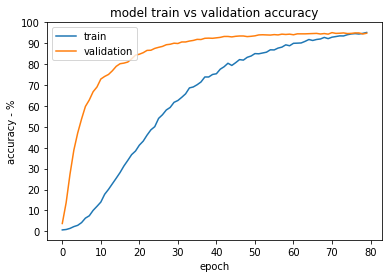

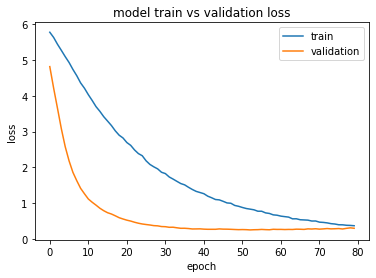

In [39]:
plot_ai(history.history)